In [13]:
import requests
from datetime import datetime, timedelta
import json
import glob
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [2]:
endpoint = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'
def request(query : str = ''):
    return requests.get(endpoint + query).json()

class request_data(object):
    data:dict = None
    query:str = None
    iso_date:str = None
    
    def __init__(self, data:dict = {}, query:str = '', iso_date:str = ''):
        self.data = data
        self.query = query
        self.iso_date = iso_date
    
def request_cached(query: str = '', cache_path = '311_query_results/', max_age : timedelta = timedelta(150), file_date_format = "%Y%m%d-%H.%M.%S") -> request_data:
    now = datetime.utcnow()

    cached_files = glob.glob(cache_path+'*.json')
    for path in cached_files:
        path = Path(path)
        file_name = path.stem
        date = re.match(r"311_query_(.*)", file_name).group(1)
        date = datetime.strptime(date, file_date_format)
        if now - date > max_age:
            continue
        with open(path, 'r', encoding='utf-8') as file:
            data_str = json.load(file)
            data = request_data()
            data.__dict__ = data_str
            if data.query == query and now - datetime.fromisoformat(data.iso_date) < max_age:
                print(path)
                return data
    
    # no matching cached data found
    fetched_data = request(query)
    data = request_data(fetched_data, query, now.isoformat())
    with open(cache_path + f'311_query_{now.strftime(file_date_format)}.json', 'w', encoding='utf-8') as file:
        json.dump(data.__dict__, file, ensure_ascii=False, indent=4)
    return data



In [3]:
x = request_cached("?$select=created_date,open_data_channel_type&$limit=10000000000")
df = pd.DataFrame(x.data)
df['created_date'] = pd.to_datetime(df['created_date']).dt.floor('d')
grouped_df = df.groupby(['created_date', 'open_data_channel_type']).size().reset_index(name='count')

311_query_results\311_query_20220721-18.35.03.json


Text(0.5, 1.0, '30 day average of means used to submit 311 cases')

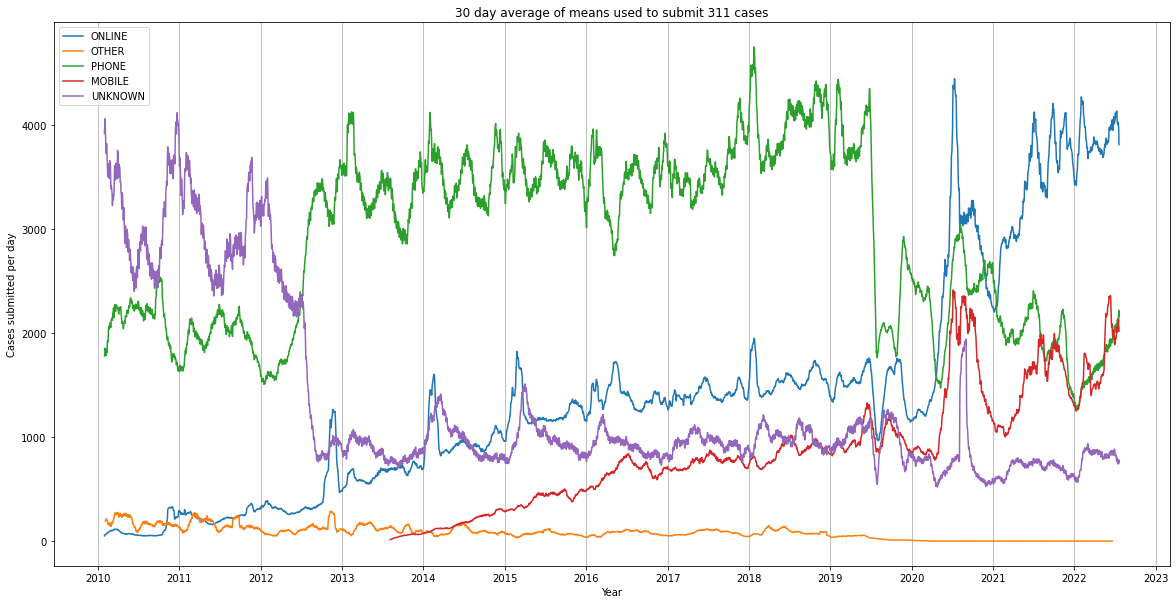

In [29]:
plt.figure(figsize=(20, 10))

window_size = 30

def plot_channel_type(type:str):
    relevant = grouped_df[grouped_df['open_data_channel_type'] == type]
    plt.plot(relevant['created_date'],  relevant['count'].rolling(window=window_size).mean(), label=type)

xaxis = plt.axes().xaxis
xaxis.set_major_locator(dates.YearLocator())
xaxis.grid(True)
plot_channel_type('ONLINE')
plot_channel_type('OTHER')
plot_channel_type('PHONE')
plot_channel_type('MOBILE')
plot_channel_type('UNKNOWN')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Cases submitted per day')
plt.title(f'{window_size} day average of means used to submit 311 cases in NYC')

In [8]:
import numpy as np

In [17]:
(df['open_data_channel_type'] != 'UaNKNOWN').sum()

29077705

In [20]:
1-6082404/29077705

0.7908224187569136